In [11]:
import control
import os
import torch

import numpy as np

from tensordict import TensorDict
from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import EnvBase
from torchrl.envs.utils import check_env_specs, set_exploration_mode

from matplotlib import pyplot as plt

from custom_environment import controllable_linear_system
from loading import init_environment, load_config, load_model


TODO 
- [x] ~~write out the equations of a linear system and the same for the discrete linear system; mention the characteristic polynomial~~
- [ ] expalin what a control task is - get a reference and output y and y has to track the reference
- [ ] add a picture of a control loop
- [x] ~~implement env here~~
- [x] ~~explain the methods that have to be overwritten~~
- [x] ~~explain specs; limiting actions makes sense~~
- [x] ~~implement in numpy but say that we could have done it in torch but for the sake of the example let's do it in numpy~~
- [x] ~~explain how the difference between the control lib output and the environment output is due to the discretization and it's exactly what we expect to see. We choose a larger timestep because it makes the environment simulation faster while training~~

### Intro
In this tutorial we'll make a custom environment for a control task with _torchrl_. We will create a class that is derived from _torchrls_ _EnvBase_ class and we'll overwritte the necessary methods and fill the values of the properties needed to make our environment conform to the _torchrl_ workflow. We'll do this on a simple example of a linear system described by the following equations:

$$
\dot{x} = Ax + Bu \\ y = Cx + Du
$$

$x$ being the state of the system and $u$ being the action; the domain and dimensionality of both these variables will be declared in our environment class using _Specs_. And since we're simulating this system on a computer we'll need the discretized version which will define our update step:

$$
\displaystyle\frac{x_{t+1} - x_t}{\Delta t} = Ax_t + Bu_t \ \Rightarrow \ x_{t+1} = x_t + \Delta t \cdot \big(Ax_t + Bu_t\big) \\ y_t = Cx_t + Du_t
$$

### Custom environment using the _EnvBase_ class

All in all our class needs to overwritte three abstract methods and initialize three properties. These methods are `_reset`, `_step` and `_set_seed`, and the properties are `action_spec`, `observation_spec` and `reward_spec`. We'll implement the computation in _numpy_ as is often the case for the sake of the example(we could have done it in _torch_ as well), however, all the communication to and from the environment will be done using tensordicts; we'll use the _device_ argument to specify the device where those incomming and outgoing tensordicts should be located.

#### Specs

`action_spec`, `observation_spec` and `reward_spec` are fields that define the range and shape of our actions, observations and rewards. They tell other modules in the library what to expect from the environment. They are some type of _TensorSpec_ depending on whether they're bounded or not, discrete or continuous. `observation_spec` is a bit of an outlier - it has to be of type _CompositeSpec_.

#### _reset(self, tensordict, **kwargs)

The `_reset` function potentialy takes in a tensordict and some kwargs which may contain data used in the reseting of the environment and returns a new tensordict with an initial observation of the environment. The output tensordict has to be new because the input tensordict is immutable. In this example we don't use the input and we just set the inital state to $\vec{0}$, but you can imagine a situation where you could use the input to initialize a state or generate a random state.

#### _step(self, tensordict)

The `_step` function takes in a tensordict from which it reads and action, applies the action and returns a new tensordict containing the observation, reward and done signal for that timestep.

#### _set_seed(self, seed)

The `_set_seed` function sets the seed of any random number generator in the environment. Here we don't use any randomness but you can imagine a scenario where we initialize the state to a random value or add noise to the output observation in which case setting the random seed for reproducibility purposes would be very helpfull.

In [12]:
class SystemEnvironment(EnvBase):

    def __init__(self, A, B, C, D, dt, ref=1, device="cpu"):
        super(SystemEnvironment, self).__init__() # call the constructor of the base class
        
        # custom property intialization - unique to this environment
        self.dtype = np.float32

        self.A, self.B, self.C, self.D, self.dt, self.ref = A, B, C, D, dt, ref
        self.device = device

        self.state_size = self.A.shape[0]
        self.action_size = self.B.shape[1]

        self.state = np.zeros((self.state_size, 1), dtype=self.dtype)
        
        # specs - needs to be initialized
        self.action_spec = BoundedTensorSpec(minimum=-1, maximum=1, shape=torch.Size([self.action_size])) # limit the action values

        observation_spec = UnboundedContinuousTensorSpec(shape=torch.Size([self.state_size])) # unlimited observation space
        self.observation_spec = CompositeSpec(observation=observation_spec) # has to be CompositeSpec(not sure why)

        self.reward_spec = UnboundedContinuousTensorSpec(shape=torch.Size([1])) # unlimited reward space(even though we could limit it to (-inf, 0] in this particular example)

    def _reset(self, tensordict, **kwargs):
        
        # init new state and pack it up in a tensordict
        
        out_tensordict = TensorDict({}, batch_size=torch.Size())

        self.state = np.zeros((self.state_size, 1), dtype=self.dtype)
        out_tensordict.set("observation", torch.tensor(self.state.flatten(), device=self.device))

        return out_tensordict

    def _step(self, tensordict):
        action = tensordict["action"]
        action = action.cpu().numpy().reshape((self.action_size, 1))

        self.state += self.dt * (self.A @ self.state + self.B @ action)

        y = self.C @ self.state + self.D @ action

        error = (self.ref - y) ** 2

        reward = -error

        out_tensordict = TensorDict({"observation": torch.tensor(self.state.astype(self.dtype).flatten(), device=self.device),
                                     "reward": torch.tensor(reward.astype(np.float32), device=self.device),
                                     "done": False}, batch_size=torch.Size())

        return out_tensordict

    def _set_seed(self, seed):
        pass

### Create the system environment

We'll create the environment and compare it's behaviour with the same system computed with the python [_control_ library](https://python-control.readthedocs.io/en/0.9.3.post2/). We create the system matrices $A$, $B$, $C$ and $D$ using a helper function _controllable_linear_system_ that takes the coefficients of the characteristic polynomial $f(s) = s^n + a_{n-1}s^{n-1} + ... + a_1s + a_0$ and returns a system in the controllable cannonical form. We choose a sampling period $\Delta t$ that's appropriate i.e. not too small(so that the simulation doesn't take too long) and not too large(so that it doesn't capture the system properties correctly).

In [13]:
dt = 1e-1  # sec; the sampling period


A, B, C, D = controllable_linear_system(a=(0.5, 1)) # get system matrices

env = SystemEnvironment(A, B, C, D, dt) # create environment object
check_env_specs(env) # check if the specs match the output of the environment

Let's check if our environment behaves as expected. As we are discretizing the system with a sampling period that's a bit on the larger side so we see a slight discrepancy between the two outputs but that's exactly what we expect.


Transfer function
 
      1
-------------
s^2 + s + 0.5



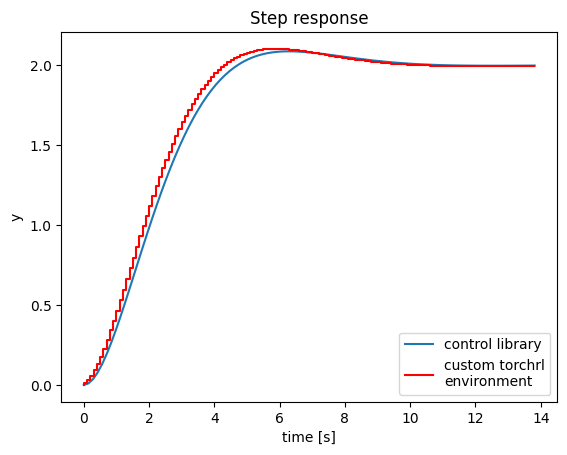

In [14]:
sys = control.ss(A, B, C, D)

transfer_func = control.tf(sys)

print("\nTransfer function\n", transfer_func)

time_axis, y_out = control.step_response(sys)

env_time_axis = np.arange(start=0, step=env.dt, stop=time_axis[-1])

# apply a unit step function to the system
rollout = env.rollout(len(env_time_axis), policy=lambda _: TensorDict({"action": 1.0}, batch_size=torch.Size()))

# extract the system output 
y_env = env.C @ rollout["next"]["observation"].cpu().numpy().T
y_env = y_env.flatten()


plt.figure()
plt.title("Step response")
plt.plot(time_axis, y_out, label="control library")
plt.step(env_time_axis, y_env, color="r", label='custom torchrl\nenvironment')
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("y")
plt.show()

### Evaluate a policy trained on this environment

Now that we've got our custom system environment we would like to train a policy on it. However, this is out of the scope of this tutorial. If you want to get familiar with that check out this(link) tutorial. Here we provide a policy that we've trained on this system and we can see that we were able to learn a policy for our custom environment using the same workflow as for the environments that come with the package.

TODO
- [ ] leave out the code and just put the picture in; the code with lots of helper functions will confuse

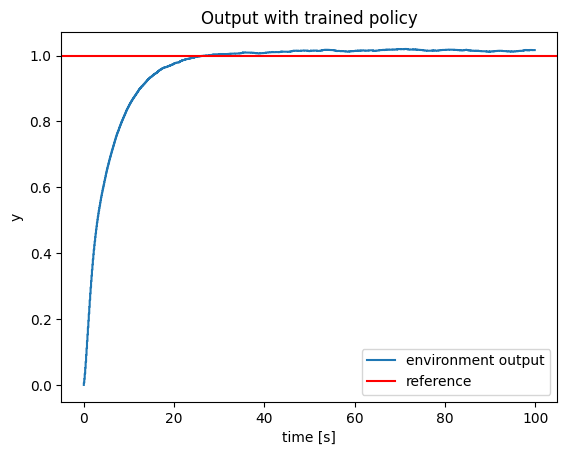

In [15]:
filepath = os.path.join("LinearSystem", "ppo", "example_trained_model.p")
config = load_config(filepath)

env = init_environment(config)

env.transform[0].loc = config["loc"].to(config["device"])
env.transform[0].scale = config["scale"].to(config["device"])

policy_module, _ = load_model(filepath, env)

with set_exploration_mode("mean"), torch.no_grad():
    # execute a rollout with the trained policy
    eval_rollout = env.rollout(config["max_eval_steps"], policy_module)

states = eval_rollout["next"]["observation"].cpu().numpy().T
states -= config["loc"].cpu().numpy()[:, np.newaxis]
states /= config["scale"].cpu().numpy()[:, np.newaxis]
y_env = env.C @ states
y_env = y_env.flatten()

env_time_axis = np.arange(start=0, step=env.dt, stop=len(y_env) * env.dt)

plt.figure()
plt.title("Output with trained policy")
plt.step(env_time_axis, y_env, label='environment output')
plt.axhline(env.ref, color='r', label='reference')
plt.xlabel("time [s]")
plt.ylabel("y")
plt.legend()

plt.show()